# Modello di deep learning per predizione dropout scolastico su dati INVALSI
Progetto del corso di **Intelligenza Artificiale**, A.A. 2020/2021

**LM Informatica**, **Alma Mater Studiorum - Università di Bologna**

Realizzato da:
- Marco Ferrati, matr. 983546
- Michele Perlino, matr. 
- Tommaso Azzalin, matr. 985911

Per info su come formattare Markdown: [clicca qui](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd).

In [8]:
import re

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

import src.config as cfg
from src.mapping_domande_ambiti_processi import MAPPING_DOMANDE_AMBITI_PROCESSI
from src.column_converters import COLUMN_CONVERTERS

## Import del dataset originale

In [ ]:
"""
Eseguire per: analisi dataset
"""
original_dataset = pd.read_csv(cfg.ORIGINAL_DATASET, sep=';', converters=COLUMN_CONVERTERS)

## Analisi dataset originale

### Ricerca colonne che abbiano percentuali di valori nulli

In [ ]:
print("Columns with high null values percentages:")
for col in original_dataset.columns:
    null_values_mean = original_dataset[col].isnull().mean()
    if null_values_mean > 0:
        print(col, '\t\tType: ', original_dataset[col].dtypes, '\tMissing values:',
                original_dataset[col].isnull().mean().round(3))

In [20]:
columns_with_high_null_values = ["codice_orario", "PesoClasse", "PesoScuola", "PesoTotale_Matematica"]
columns_with_lower_null_values = [
    "voto_scritto_ita",  # 0.683
    "voto_scritto_mat",  # 0.113
    "voto_orale_ita",  # 0.683
    "voto_orale_mat"  # 0.114
]

### Ricerca colonne con valori univoci (o quasi)

In [ ]:
dataset_len = len(original_dataset)
print("Columns with unique values:")
for col in original_dataset.columns:
    unique_vals = original_dataset[col].nunique()
    if unique_vals / dataset_len > 0.1:
        print(col, "ratio = ", round(unique_vals / dataset_len, 3))

In [ ]:
columns_with_unique_values = ["Unnamed: 0", "CODICE_STUDENTE"]

### Ricerca colonne con valori sempre uguali

In [ ]:
print("Columns with just one value:")
for col in original_dataset.columns:
    unique_vals = original_dataset[col].nunique()
    if unique_vals == 1:
        print(col)

In [ ]:
columns_with_just_one_value = ["macrotipologia", "livello"]

### Rimozione delle colonne superflue

In [ ]:
"""
Eseguire per: analisi dataset
"""
cleaned_original_dataset: pd.DataFrame = original_dataset.drop(
    columns_with_high_null_values + 
    columns_with_unique_values + 
    columns_with_just_one_value, 
    axis=1
)
cleaned_original_dataset.to_csv(cfg.CLEANED_DATASET)

In [ ]:
"""
Eseguire per: analisi dataset
Attenzione: inutile eseguire se si è eseguita la precedente cella.
"""
cleaned_original_dataset = pd.read_csv(cfg.CLEANED_DATASET)

In [ ]:
if "Unnamed: 0" in cleaned_original_dataset.columns:
    cleaned_original_dataset.drop("cleaned_original_dataset", axis=1, inplace=True)

## Generalizzazione dataset per supporto di altre coorti di studenti

In [9]:
list_ambiti_processi = [AP for val in MAPPING_DOMANDE_AMBITI_PROCESSI.values() for AP in val]
ambiti_processi = set(list_ambiti_processi)
conteggio_ambiti_processi = {AP: list_ambiti_processi.count(AP) for AP in ambiti_processi}   

In [ ]:
"""
Eseguire per: analisi dataset
"""
dataset_with_ambiti_processi = cleaned_original_dataset.copy()
for AP in ambiti_processi:
    # Aggiunge una colonna al dataset chiamata AP e inizializza tutti i record a 0.0
    dataset_with_ambiti_processi[AP] = 0.0

In [ ]:
"""
Eseguire per: rimozione feature sulle domande e aggiunta feature sugli ambiti e processi
"""
questions_columns = [col for col in list(cleaned_original_dataset) if re.search("^D\d", col)]

for i, row in dataset_with_ambiti_processi.iterrows():
    for question, APs in MAPPING_DOMANDE_AMBITI_PROCESSI.items():
        if row[question] == True:
            for AP in APs:
                dataset_with_ambiti_processi.at[i, AP] += 1 / conteggio_ambiti_processi[AP]

dataset_ap = dataset_with_ambiti_processi.drop(questions_columns, axis=1)

dataset_ap.to_csv(cfg.CLEANED_DATASET_WITH_AP)

In [10]:
"""
Eseguire per: rimozione feature sulle domande e aggiunta feature sugli ambiti e processi
Attenzione: inutile eseguire se si è eseguita la precedente cella.
"""
dataset_ap = pd.read_csv(cfg.CLEANED_DATASET_WITH_AP)

In [11]:
if "Unnamed: 0" in dataset_ap.columns:
    dataset_ap.drop("Unnamed: 0", axis=1, inplace=True)

## Analisi correlazione fra feature

In [ ]:
corr_matrix = dataset_ap.corr(method='pearson').round(2)
corr_matrix.style.background_gradient(cmap='YlOrRd')

In [ ]:
interisting_to_check_if_correlated_columns = [
    # Alta correlazione fra voti della stessa materia, abbastanza correlate fra materie diverse
    "voto_scritto_ita",
    "voto_orale_ita",
    "voto_scritto_mat",
    "voto_orale_mat",
    # Correlazione totale, abbastanza correlate con voti
    "pu_ma_gr",
    "pu_ma_no"
] + list(ambiti_processi)

In [ ]:
check_corr_dataset = dataset_ap[interisting_to_check_if_correlated_columns].corr(method='pearson').round(2)
check_corr_dataset.style.background_gradient(cmap='YlOrRd')

### Rimozione colonne altamente correlate

In [ ]:
# TODO Rimozione colonne altamente correlate

## Analisi dei tipi delle colonne

In [ ]:
print("Lista colonne e tipi:")
print(dataset_ap.info())

In [21]:
continuous_features = columns_with_lower_null_values + \
                      ["pu_ma_gr", "pu_ma_no", "Fattore_correzione_new", "Cheating", "WLE_MAT", "WLE_MAT_200", "WLE_MAT_200_CORR",
                       "pu_ma_no_corr"] + \
                      list(ambiti_processi) # Feature sui voti, feature elencate, ambiti e processi
ordinal_features = [
    "n_stud_prev", "n_classi_prev", "LIVELLI"
]
int_categorical_features = [
    "CODICE_SCUOLA", "CODICE_PLESSO", "CODICE_CLASSE", "campione", "prog",
]
str_categorical_features = [
    "sesso", "mese", "anno", "luogo", "eta", "freq_asilo_nido", "freq_scuola_materna",
    "luogo_padre", "titolo_padre", "prof_padre", "luogo_madre", "titolo_madre", "prof_madre",
    "regolarità", "cittadinanza", "cod_provincia_ISTAT", "Nome_reg",
    "Cod_reg", "Areageo_3", "Areageo_4", "Areageo_5", "Areageo_5_Istat"
]
bool_features = ["Pon"]

## Aggiustamento colonne con valori nulli

In [ ]:
dataset_ap["sigla_provincia_istat"].fillna(value="ND", inplace=True)
# TODO Trovare un modo migliore per effettuare il rimpiazzo dei non disponibili.
dataset_ap["voto_scritto_ita"].fillna(value=dataset_ap["voto_scritto_ita"].mean(), inplace=True)
dataset_ap["voto_orale_ita"].fillna(value=dataset_ap["voto_orale_ita"].mean(), inplace=True)
dataset_ap["voto_scritto_mat"].fillna(value=dataset_ap["voto_scritto_mat"].mean(), inplace=True)
dataset_ap["voto_orale_mat"].fillna(value=dataset_ap["voto_orale_mat"].mean(), inplace=True)

## Analisi e risoluzione dello sbilanciamento del dataset

In [ ]:
nr_nodrop, nr_drop = np.bincount(dataset_ap['DROPOUT'])
total_records = nr_drop + nr_nodrop
print(
    f"Total number of records: {total_records} - \
Total num. DROPOUT: {nr_drop} - \
Total num. NO DROPOUT: {nr_nodrop} - \
Ratio DROPOUT/TOTAL: {round(nr_drop / total_records, 2)} - \
Ratio NO DROPOUT/TOTAL: {round(nr_nodrop / total_records, 2)} - \
Ratio DROPOUT/NO DROPOUT: {round(nr_drop / nr_nodrop, 2)}"
)

### Random undersampling

In [ ]:
"""
Eseguire per: undersampling
"""
# class_nodrop contiene i record della classe sovrarappresentata, ovvero SENZA DROPOUT.
class_nodrop = dataset_ap[dataset_ap['DROPOUT'] == False]
# class_drop contiene i record della classe sottorappresentata, ovvero CON DROPOUT.
class_drop = dataset_ap[dataset_ap['DROPOUT'] == True]

# Sotto campionamento di class_drop in modo che abbia stessa cardinalità di class_nodrop
class_nodrop = class_nodrop.sample(len(class_drop))

print(f'Class NO DROPOUT: {len(class_nodrop):,}')
print(f'Classe DROPOUT: {len(class_drop):,}')

sampled_dataset = class_drop.append(class_nodrop)
sampled_dataset = sampled_dataset.sample(frac=1)

sampled_dataset.to_csv(cfg.UNDERSAMPLED_DATASET, index=False)

In [ ]:
"""
Eseguire per: undersampling
Attenzione: inutile eseguire se si è eseguita la precedente cella.
"""
sampled_dataset = pd.read_csv(cfg.UNDERSAMPLED_DATASET)

In [ ]:
sampled_dataset = dataset_ap.copy()

In [ ]:
if "Unnamed: 0" in sampled_dataset.columns:
    sampled_dataset.drop("Unnamed: 0", axis=1, inplace=True)

### Oversampling con SMOTE

## Preprocessing per creazione del modello di Deep Learning

In [ ]:
ml_dataset = sampled_dataset.copy()

In [12]:
ml_dataset = pd.read_csv(cfg.ML_DATASET)

In [13]:
if "Unnamed: 0" in ml_dataset.columns:
    ml_dataset.drop("Unnamed: 0", axis=1, inplace=True)

### Suddivisione del dataset in training, validation e test

In [14]:
df_training_set, df_test_set = train_test_split(ml_dataset, test_size=cfg.TEST_SET_PERCENT)
df_training_set, df_validation_set = train_test_split(df_training_set, test_size=cfg.VALIDATION_SET_PERCENT)

### Conversione dei dati da DataFrame (Pandas) a Dataset (Tensorflow/Keras)

In [15]:
def dataframe_to_dataset(dataframe: pd.DataFrame):
    copied_df = dataframe.copy()
    dropout_col = copied_df.pop("DROPOUT")
    """
    Dato che il dataframe ha dati eterogenei lo convertiamo a dizionario,
    in cui le chiavi sono i nomi delle colonne e i valori sono i valori della colonna.
    Infine bisogna indicare la colonna target.
    """
    tf_dataset = tf.data.Dataset.from_tensor_slices((dict(copied_df), dropout_col))
    tf_dataset = tf_dataset.shuffle(buffer_size=len(copied_df))
    return tf_dataset

In [16]:
ds_training_set = dataframe_to_dataset(df_training_set)
ds_validation_set = dataframe_to_dataset(df_validation_set)
ds_test_set = dataframe_to_dataset(df_test_set)

### Suddivisione del dataset in batch

In [17]:
ds_training_set = ds_training_set.batch(cfg.BATCH_SIZE, drop_remainder=True)
ds_validation_set = ds_validation_set.batch(cfg.BATCH_SIZE, drop_remainder=True)
ds_test_set = ds_test_set.batch(cfg.BATCH_SIZE, drop_remainder=True)

### Creazione dei layer di input per ogni feature

In [22]:
input_layers = {}
for name, column in df_training_set.items():
    if name == "DROPOUT":
        continue

    if name in continuous_features:
        dtype = tf.float32
    elif name in ordinal_features or name in int_categorical_features or name in bool_features:
        dtype = tf.int64
    else:  # str_categorical_features
        dtype = tf.string

    input_layers[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

### Encoding delle feature in base al loro tipo

In [23]:
preprocessed_features = []


def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [24]:
# Preprocessing colonne con dati booleani
for name in bool_features:
    inp = input_layers[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed_features.append(float_value)

In [25]:
# Preprocessing colonne con dati interi ordinali
ordinal_inputs = {}
for name in ordinal_features:
    ordinal_inputs[name] = input_layers[name]

normalizer = Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(df_training_set[ordinal_features])))
ordinal_inputs = stack_dict(ordinal_inputs)
ordinal_normalized = normalizer(ordinal_inputs)
preprocessed_features.append(ordinal_normalized)

In [26]:
# Preprocessing colonne con dati continui
continuous_inputs = {}
for name in continuous_features:
    continuous_inputs[name] = input_layers[name]

normalizer = Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(df_training_set[continuous_features])))
continuous_inputs = stack_dict(continuous_inputs)
continuous_normalized = normalizer(continuous_inputs)
preprocessed_features.append(continuous_normalized)

In [27]:
# Preprocessing colonne con dati categorici stringa
for name in str_categorical_features:
    vocab = sorted(set(df_training_set[name]))

    lookup = StringLookup(vocabulary=vocab, output_mode='one_hot')

    x = input_layers[name][:, tf.newaxis]
    x = lookup(x)

    preprocessed_features.append(x)

In [28]:
# Preprocessing colonne con dati categorici interi
for name in int_categorical_features:
    vocab = sorted(set(df_training_set[name]))

    lookup = IntegerLookup(vocabulary=vocab, output_mode='one_hot')

    x = input_layers[name][:, tf.newaxis]
    x = lookup(x)

    preprocessed_features.append(x)

### Assemblaggio dei vari layer e creazione del modello

In [29]:
# initializer = tf.keras.initializers.glorot_uniform(seed=19)

preprocessed = tf.concat(preprocessed_features, axis=-1)

preprocessor = tf.keras.Model(input_layers, preprocessed)

body = tf.keras.Sequential(
    [tf.keras.layers.Dense(cfg.NEURONS, activation=cfg.DENSE_LAYER_ACTIVATION) for _ in range(cfg.NUMBER_OF_LAYERS)] +
    [tf.keras.layers.Dropout(cfg.DROPOUT_LAYER_RATE)] if cfg.DROPOUT_LAYER else [] +
    [tf.keras.layers.Dense(1, activation=cfg.OUTPUT_ACTIVATION_FUNCTION)]
)

x = preprocessor(input_layers)

result = body(x)

model = tf.keras.Model(input_layers, result)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Acquisire progressivamente form [(None,)]            0                                            
__________________________________________________________________________________________________
Areageo_3 (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
Areageo_4 (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
Areageo_5 (InputLayer)          [(None,)]            0                                            
____________________________________________________________________________________________

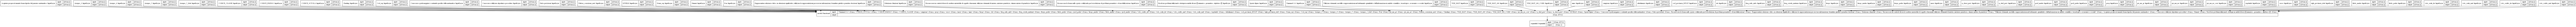

In [30]:
# Visualizzazione tabellare del modello
from keras.utils.vis_utils import plot_model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

### Compilazione del modello e scelta delle metriche

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[
                  tf.metrics.Accuracy(),
                  tf.metrics.BinaryAccuracy(),
                  tf.metrics.Precision(),
                  tf.metrics.Recall(),
                  tf.metrics.FalseNegatives(),
                  tf.metrics.FalsePositives(),
                  tf.metrics.TrueNegatives(),
                  tf.metrics.TruePositives()])

### Training

In [34]:
model.fit(ds_training_set, epochs=5, batch_size=cfg.BATCH_SIZE, validation_data=ds_validation_set, verbose=2)

Epoch 1/5
4671/4671 - 56s - loss: 1.5473e-05 - accuracy: 0.2341 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 74594.0000 - true_positives: 74878.0000 - val_loss: 1.1685e-05 - val_accuracy: 0.2313 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 18693.0000 - val_true_positives: 18651.0000
Epoch 2/5
4671/4671 - 57s - loss: 5.0983e-06 - accuracy: 0.2341 - binary_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 74594.0000 - true_positives: 74878.0000 - val_loss: 3.9519e-06 - val_accuracy: 0.2313 - val_binary_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 18702.0000 - val_true_positives: 18642.0000


### Test

In [ ]:
score = model.evaluate(ds_test_set)

## Risultati ottenuti


| Epoche | Neuroni | Batch | Tecnica di sampling | Layer lineari | Tasso apprendimento | Dropout | Tasso di dropout | Accuratezza in training | Accuratezza in test | Note aggiuntive |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|     10 |     128 |    32 |       Undersampling |            10 |               0.001 |      No |                - |                  0.2339 |              0.2336 | C'erano colonne con alta correlazione. |
|     50 |     128 |    32 |       Undersampling |            10 |               0.001 |      No |                - |                  0.6938 |              0.6874 | C'erano colonne con alta correlazione. |
|     50 |     256 |    32 |       Undersampling |            10 |               0.001 |      No |                - |                  0.6944 |              0.6873 | C'erano colonne con alta correlazione. |
|     50 |     128 |   128 |       Undersampling |            10 |               0.001 |      No |                - |                  0.2386 |              0.2341 | C'erano colonne con alta correlazione. Perché è così pessimo il risultato? |